In [ ]:
import sys
sys.path.append('your-path-to-the-repo')
from tqdm import tqdm
import pickle as pkl
import numpy as np
import tensorflow as tf
from train import create_gen_input
import os
import subprocess

from dataset import get_dataset_mnist_n2n
from matplotlib import pyplot as plt
from visualisations.validation import best_of_n
from settings import IMAGESIZE, CHANNELS

import numpy as np
import math
import tensorflow as tf

_, _, test_dataset = get_dataset_mnist_n2n(std=1.1)
test_dataset = test_dataset.batch(100)
from collections import defaultdict
from models_mnist import create_generator, create_discriminator

def restore_dgan_checkpoint(model_number, checkpoint_number):
    generator_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
                0.0004,
                decay_steps=100000,
                decay_rate=0.9)
    discriminator_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
        0.0004,
        decay_steps=100000,
        decay_rate=0.9)
    generator = create_generator()
    discriminator = create_discriminator()
    generator_optimizer = tf.keras.optimizers.Adam(generator_scheduler)
    discriminator_optimizer = tf.keras.optimizers.Adam(discriminator_scheduler)
    ckpt = tf.train.Checkpoint(step=tf.Variable(0), generator_optimizer=generator_optimizer, generator_model=generator,
                                   discriminator_optimizer=discriminator_optimizer, discriminator_model=discriminator)
    ckpt.restore(MAIN_CHECKPOINTS_PATH + '/{}/ckpt-{}'.format(model_number, checkpoint_number))
    return generator

def best_of_n(model, noisy, clean, images_number=100):
    z_val = np.random.normal(0, 1, [images_number, IMAGESIZE, IMAGESIZE, 1])
    z_val /= np.linalg.norm(z_val, axis=(1, 2))[:, None, None]
    images = np.tile(tf.reshape(noisy, [1] + noisy.shape), [images_number, 1, 1, 1])
    gen_input = np.concatenate([images, z_val], axis=-1)
    out = model(gen_input)
    mses = np.mean(((out-clean)**2), axis=(1,2,3))
    indices = np.argsort(mses)
    #sorted_out = tf.gather(out, indices)
    return out, indices

def create_figure(model_number, checkpoint_number, test_set):
    model = restore_dgan_checkpoint(model_number, checkpoint_number)
    images = get_images(model, test_set)
    fig = create_image_grid(images)
    

In [ ]:
from dataset import get_dataset_mnist_n2n
import random

MAIN_CHECKPOINTS_PATH = 'path-to-models'

_, _, test_dataset = get_dataset_mnist_n2n(std=1.1)
def get_display_images(model_name, checkpoint):
    generator = restore_dgan_checkpoint(model_name, checkpoint)
    display_images = []
    for clean, noisy, _ in test_dataset.skip(1).take(3):
        out, indices = best_of_n(generator, noisy, clean)
        random_index1, random_index2 = random.sample(list(indices)[1:-1], 2)
        best = out[indices[0]]
        worst = out[indices[-1]]
        random1 = out[random_index1]
        random2 = out[random_index2]
        display_images.append([clean, noisy, best, worst, random1, random2])
    return display_images

display_images_high_div_loss = get_display_images('1131_87Z06', 49)
display_images_low_div_loss = get_display_images('1129_ETY7I', 61)

Text(0.5, 1.0, 'MSE loss multiplier 2000, Div loss multiplier 0.')

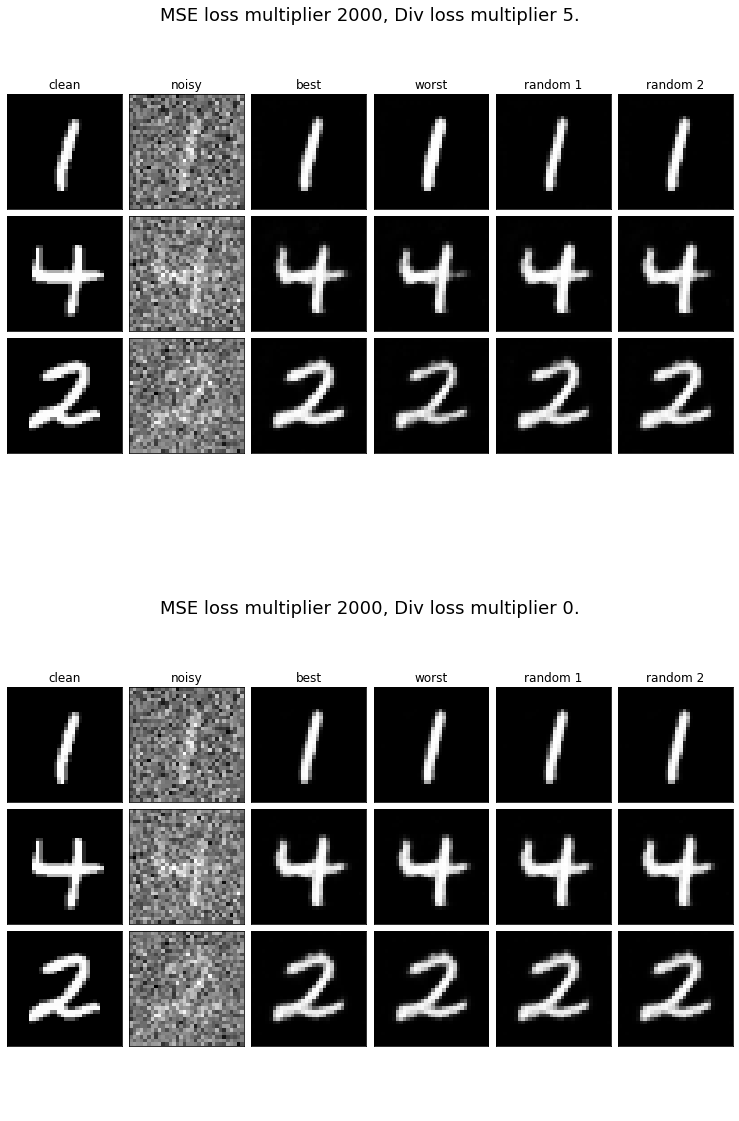

In [3]:
from mpl_toolkits.axes_grid1 import ImageGrid
images_names  = ['clean', 'noisy', 'best', 'worst', 'random 1', 'random 2']
fig, (ax1, ax2) = plt.subplots(2, figsize=[13, 20])
ax1.set_axis_off()
ax2.set_axis_off()

grid1 = ImageGrid(fig, 211,  # similar to subplot(111)
                 nrows_ncols=(3, 6),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for idx, subax in enumerate(grid1):
    # Iterating over the grid returns the Axes.
    example_number = idx // len(images_names)
    image_name = images_names[idx % len(images_names)]
    im = display_images_high_div_loss[example_number][idx % len(images_names)]
    subax.imshow(np.squeeze(im), cmap='gray')
    plt.setp(subax.get_xticklabels(), visible=False)
    plt.setp(subax.get_yticklabels(), visible=False)
    subax.tick_params(axis=u'both', which=u'both', length=0)
    if idx < len(images_names):
        subax.set_title(image_name)
ax1.set_title('MSE loss multiplier 2000, Div loss multiplier 5.', fontsize=18)
        
grid2 = ImageGrid(fig, 212,  # similar to subplot(111)
                 nrows_ncols=(3, 6),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )        

for idx, subax in enumerate(grid2):
    # Iterating over the grid returns the Axes.
    example_number = idx // len(images_names)
    image_name = images_names[idx % len(images_names)]
    im = display_images_low_div_loss[example_number][idx % len(images_names)]
    subax.imshow(np.squeeze(im), cmap='gray')
    plt.setp(subax.get_xticklabels(), visible=False)
    plt.setp(subax.get_yticklabels(), visible=False)
    subax.tick_params(axis=u'both', which=u'both', length=0)
    if idx < len(images_names):
        subax.set_title(image_name)
ax2.set_title('MSE loss multiplier 2000, Div loss multiplier 0.', fontsize=18)

    